In [1]:
import pandas as pd
import numpy as np 

### Merging different sets of metrics in one dataframe

In [2]:
df1 = pd.read_csv('bug-metrics.csv')
df1 = df1.drop(columns = ['nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs'])
df2 = pd.read_csv('change-metrics.csv')
df2 = df2.drop(columns = ['nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs'])
df = pd.merge(df1, df2, on = ['classname','bugs'])
df3 = pd.read_csv('lin-ent.csv')
df3 = df3.drop(columns = ['nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs'])
df = pd.merge(df, df3, on = ['classname', 'bugs'] )
df4 = pd.read_csv('complexity-code-change.csv')
df = pd.merge(df, df4, on='classname')

### Separating features and target and feature scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler

# --> Debugging statements

from sklearn.model_selection import train_test_split
##print(df.columns)

# classname has no use and the unnamed column was created due to a wrongly placed space
# will clear it in the future
df = df.drop(columns=['classname'])

##print(df.dtypes)
df.dropna()

#Removing the actual bug count column to extract the metrics
X = df.loc[:, df.columns != 'bugs']
Y = df['bugs']

##print(X.dtypes)

X = X.apply(pd.to_numeric)
##print(X.head())
X_asDF = X

# Feature Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Y = [(float(i)-min(Y))/(max(Y)-min(Y)) for i in Y]

### Extracting top 5 metrics and calculating Ru

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

from sklearn.linear_model import LinearRegression
import operator

reg = LinearRegression()

for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict( sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
#print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

0.5490264761576464


### Calculating weights for the selected features

In [5]:
d = []
for i in list_keys:
    remaining_features = [j for j in list_keys if j != i ]
    X_train_remaining = X_train[:,remaining_features]
    # X_test_remaining = X_test[:,remaining_features]
    reg.fit(X_train_remaining, Y_train)
    train_score = reg.score(X_train_remaining, Y_train)
    print(train_score)
    d.append(rU-train_score)

0.5404712079771785
0.5421514586147131
0.5458549186309055
0.548752196228031
0.546266253482119


### Normalising weights for and predicting the bug proneness index

In [6]:
norm_d = [(float(i)-min(d))/(max(d)-min(d)) for i in d]
print(norm_d)
#Weights should be mapped to elements in the list_keys
#norm_d are the normalized weights of the n metrics

Y_pred = []

#print(list_keys)
for features_test in X_test:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_test[i] * wt
    Y_pred.append(tot)
    
  

[1.0, 0.7970953965111994, 0.3498709947846131, 0.0, 0.30019880123076625]


### Printing the predicted and the actual target

In [7]:
## The paper doesn't mention normalising again but some values don't lie in the range of 0 to 1
## Hence normalising again
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
Y_pred_final = [round(i,4) for i in Y_pred]
Y_test_final = [round(i,4) for i in Y_test]
for(predicted, actual) in zip(Y_pred_final, Y_test_final):
    print(f"{predicted} - {actual}") 
    print()

0.5328 - 0.1111

0.0169 - 0.0

0.185 - 0.0

0.0 - 0.0

0.0128 - 0.0

0.0006 - 0.0

0.0047 - 0.0

0.0874 - 0.1111

0.0024 - 0.0

0.0349 - 0.0

0.0071 - 0.0

0.0196 - 0.0

0.0 - 0.1111

0.0 - 0.0

0.0131 - 0.0

0.0071 - 0.1111

0.0172 - 0.0

0.0101 - 0.0

0.0508 - 0.0

0.0 - 0.0

0.0024 - 0.0

0.0192 - 0.0

0.0573 - 0.2222

0.0024 - 0.0

0.0139 - 0.0

0.0 - 0.0

0.0406 - 0.0

0.1552 - 0.0

0.0024 - 0.0

0.0965 - 0.0

0.0 - 0.0

0.0024 - 0.0

0.0144 - 0.0

0.0518 - 0.0

0.1261 - 0.0

0.0213 - 0.0

0.0077 - 0.0

0.0342 - 0.0

0.0024 - 0.0

0.0 - 0.0

0.0 - 0.2222

0.0231 - 0.0

0.1525 - 0.0

0.0676 - 0.0

0.1014 - 0.0

0.0102 - 0.0

0.1016 - 0.1111

0.032 - 0.0

0.277 - 0.4444

0.1871 - 0.4444

0.0238 - 0.1111

0.0359 - 0.1111

0.0071 - 0.0

0.0 - 0.0

0.0179 - 0.0

0.0449 - 0.0

0.0 - 0.0

0.0439 - 0.0

0.0125 - 0.1111

0.1912 - 0.2222

0.0 - 0.0

0.1995 - 0.5556

0.0366 - 0.0

0.0 - 0.0

0.0256 - 0.0

0.4213 - 0.1111

0.0136 - 0.0

0.0095 - 0.0

0.0 - 0.0

0.0047 - 0.0

0.106 - 0.1111

0

In [8]:
## For comparison and visualization 
# For Linear
print(Y_pred[:5])

[0.5327692852842281, 0.01690233241257171, 0.18495033531538796, 0.0, 0.012806328811375587]


In [9]:
print(Y_test[:20])

[0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0]


In [10]:
df.head()

,numberOfBugsFoundUntil:,numberOfNonTrivialBugsFoundUntil:,numberOfMajorBugsFoundUntil:,numberOfCriticalBugsFoundUntil:,numberOfHighPriorityBugsFoundUntil:,bugs,numberOfVersionsUntil:,numberOfFixesUntil:,numberOfRefactoringsUntil:,numberOfAuthorsUntil:,...,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc,CvsEntropy,CvsWEntropy,CvsLinEntropy,CvsLogEntropy,CvsExpEntropy
0,3,2,0,0,0,0,65,4,0,8,...,0.0,0.000000,0.000000,0.000000,0.000000,10.91310,0.008302,0.014767,0.253257,0.001125
1,0,0,0,0,0,0,2,0,0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,1.10349,0.000657,0.001886,0.027116,0.000351
2,55,48,6,4,2,1,120,10,0,12,...,0.0,0.000000,0.000905,0.036114,0.041101,37.86060,0.228509,0.106180,1.028400,0.210412
3,3,3,0,0,0,0,28,4,0,5,...,0.0,0.000000,0.001756,0.002711,0.002314,5.86013,0.009105,0.010113,0.143680,0.003485
4,15,13,1,1,0,0,93,17,0,8,...,0.0,0.000695,0.000000,0.003749,0.001594,13.59600,0.016005,0.025751,0.338602,0.021378


## Function to classify bug count to 0 or 1

In [11]:
def classification(to_convert):
    final_list=[]
    for i in to_convert:
        if i>0.08:
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

In [12]:
Y_test_classified=classification(Y_test_final)
Y_pred_classified=classification(Y_pred_final)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_classified,Y_pred_classified))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       159
           1       0.62      0.61      0.62        41

    accuracy                           0.84       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.84      0.84      0.84       200



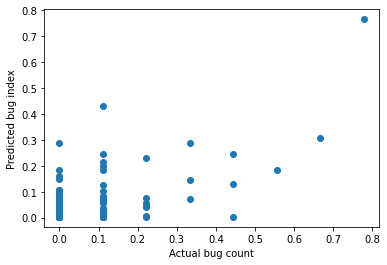

In [14]:
# Plotting of simple linear regression model

import matplotlib.pyplot as plt
X_train_for_singlefeat = X_train[:,list_keys[0]]
X_test_for_singlefeat = X_test[:,list_keys[0]]
X_train_for_singlefeat = X_train_for_singlefeat.reshape(-1,1)
reg.fit(X_train_for_singlefeat,Y_train)
X_test_for_singlefeat_2d = X_test_for_singlefeat.reshape(-1,1)
Y_Predicted = reg.predict(X_test_for_singlefeat_2d)
#plt.scatter(X_test_for_singlefeat_2d,Y_test_final)
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
#Y_test_final_arr = np.array(Y_test_final)
#slope,intercept = np.polyfit(Y_test_final_arr,Y_pred_final,1)
#Y_intercept = slope*Y_test_final_arr + intercept
#plt.plot(X_test_for_singlefeat_2d,Y_Predicted)
plt.scatter(Y_test_final,Y_Predicted)

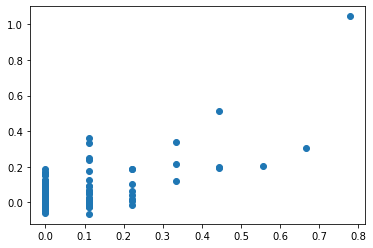

In [15]:
# Plotting of multiple linear regression

reg.fit(X_train,Y_train)
Y_Pred_multiplereg = reg.predict(X_test)
#plt.plot(Y_test,Y_Predicted_multiplereg)
plt.scatter(Y_test,Y_Pred_multiplereg)

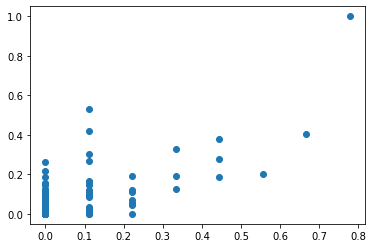

In [16]:
# Plotting of prosposed model

plt.scatter(Y_test_final,Y_pred_final)

## Classificaton report for testing data
### Simple Linear regression

In [17]:
reg.fit(X_train_for_singlefeat,Y_train)
Y_pred_simple = reg.predict(X_test_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_simple)))


Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       159
           1       0.63      0.41      0.50        41

    accuracy                           0.83       200
   macro avg       0.75      0.68      0.70       200
weighted avg       0.81      0.83      0.82       200



### Multiple Linear regression

In [18]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_test)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       159
           1       0.59      0.49      0.53        41

    accuracy                           0.82       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.82      0.82      0.82       200



### Proposed model

In [19]:
reg.fit(X_train_for_multiple,Y_train)
Y_pred_proposed = reg.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_proposed)))

Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       159
           1       0.66      0.51      0.58        41

    accuracy                           0.84       200
   macro avg       0.77      0.72      0.74       200
weighted avg       0.83      0.84      0.84       200



### Applying classification models to the proposed model(5 selected features)

In [20]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB,ComplementNB
Y = df['bugs']
Y_nb = []
print(set(Y))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [21]:
clf = GaussianNB()
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)

from sklearn.metrics import accuracy_score,classification_report
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       159
           1       0.66      0.51      0.58        41

    accuracy                           0.84       200
   macro avg       0.77      0.72      0.74       200
weighted avg       0.83      0.84      0.84       200



In [23]:
clf = ComplementNB()
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       159
           1       0.30      0.56      0.39        41

    accuracy                           0.64       200
   macro avg       0.58      0.61      0.57       200
weighted avg       0.74      0.64      0.67       200



In [24]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = "entropy", splitter="random",min_samples_split=3)
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       159
           1       0.49      0.41      0.45        41

    accuracy                           0.79       200
   macro avg       0.67      0.65      0.66       200
weighted avg       0.78      0.79      0.78       200



In [25]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='saga', penalty = 'l2', C = 0.1, random_state=10)
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       159
           1       1.00      0.10      0.18        41

    accuracy                           0.81       200
   macro avg       0.91      0.55      0.54       200
weighted avg       0.85      0.81      0.75       200



In [26]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       159
           1       0.67      0.39      0.49        41

    accuracy                           0.83       200
   macro avg       0.76      0.67      0.70       200
weighted avg       0.82      0.83      0.82       200



In [27]:
from sklearn.ensemble import RandomForestClassifier
rfs = RandomForestClassifier(n_estimators=200, criterion = "gini")
clf.fit(X_train_for_multiple, classification(Y_train))
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       159
           1       0.67      0.39      0.49        41

    accuracy                           0.83       200
   macro avg       0.76      0.67      0.70       200
weighted avg       0.82      0.83      0.82       200

